# **Introducción**
En la era moderna, la calidad del aire se ha convertido en una preocupación creciente para la salud pública y el medio ambiente. La polución atmosférica, resultante de diversas actividades humanas y fenómenos naturales, afecta la salud respiratoria y cardiovascular de millones de personas y contribuye al cambio climático global. En este contexto, la capacidad de predecir niveles de polución con alta precisión es una herramienta vital para la toma de decisiones informadas y la implementación de políticas efectivas.

Este proyecto se centra en la aplicación de redes neuronales de memoria a corto y largo plazo (**LSTM**) para la predicción de la polución del aire, utilizando como covariables la temperatura, presión, punto de rocío, velocidad del viento, nieve y lluvia. Adicionalmente, se emplea la técnica de permuted feature importances para evaluar la relevancia de cada una de estas covariables en el modelo predictivo (**PFI**). Al combinar la potencia de las LSTM con análisis de importancia de características, este enfoque no solo mejora la precisión de las predicciones, sino que también ofrece insights valiosos sobre los factores que más influyen en los niveles de polución.

El objetivo de este proyecto de muestra es la elaboración de un modelo de **multivariado** **unistep** (un valor predicho para la variable objetivo en función de la información aportada por cada conjunto de datos compuesto por ella misma y sus covariables) para la variable "pollution" y usar la técnica de PFI para desvelar cuales son las características que tienen más peso dentro del conjunto.




Importación de dependencias

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime as dt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import RMSprop
import warnings
warnings.filterwarnings("ignore")

## **Análisis exploratorio**
En esta primera sección el enfoque se centra en verificar y ajustar la resolución temporal, la visualización y identificación de la estacionalidad en la variable objetivo (si es que existe) y su tendencia

In [ ]:
raw_df = pd.read_csv("LSTM-Multivariate_pollution.csv")
raw_df.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [ ]:
#Ajustando la variable "date" a tipo de dato datetime y llevandola a su respectivo formato
raw_df["date"] = pd.to_datetime(raw_df["date"], format="%Y-%m-%d %H:%M:%S")
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       43800 non-null  datetime64[ns]
 1   pollution  43800 non-null  float64       
 2   dew        43800 non-null  int64         
 3   temp       43800 non-null  float64       
 4   press      43800 non-null  float64       
 5   wnd_dir    43800 non-null  object        
 6   wnd_spd    43800 non-null  float64       
 7   snow       43800 non-null  int64         
 8   rain       43800 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(1)
memory usage: 3.0+ MB


In [ ]:
#verificación de información faltante
raw_df.isna().sum()

date         0
pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64

In [ ]:
#Conviertiendo los indices del conjunto de datos a su tiempo de medición respectiva
raw_df.set_index(["date"], inplace= True)
raw_df.sort_index()
raw_df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [ ]:
#verificación de la equitatividad entre la distancia de todas las mediciones realizadas y copia de data original
poll_df = raw_df.copy()
dt_dif = poll_df.index.to_series().diff().dt.total_seconds()
print(dt_dif.value_counts())

date
3600.0    43799
Name: count, dtype: int64


In [ ]:
raw_df.describe()

,pollution,dew,temp,press,wnd_spd,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


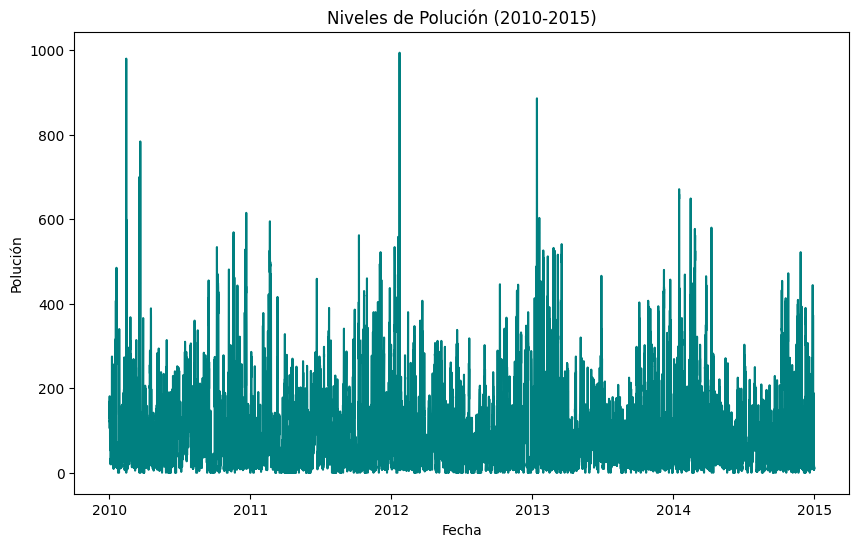

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(raw_df.index, raw_df['pollution'], label='Pollution', color = "teal")
plt.title('Niveles de Polución (2010-2015)')
plt.xlabel('Fecha')
plt.ylabel('Polución')
plt.show()

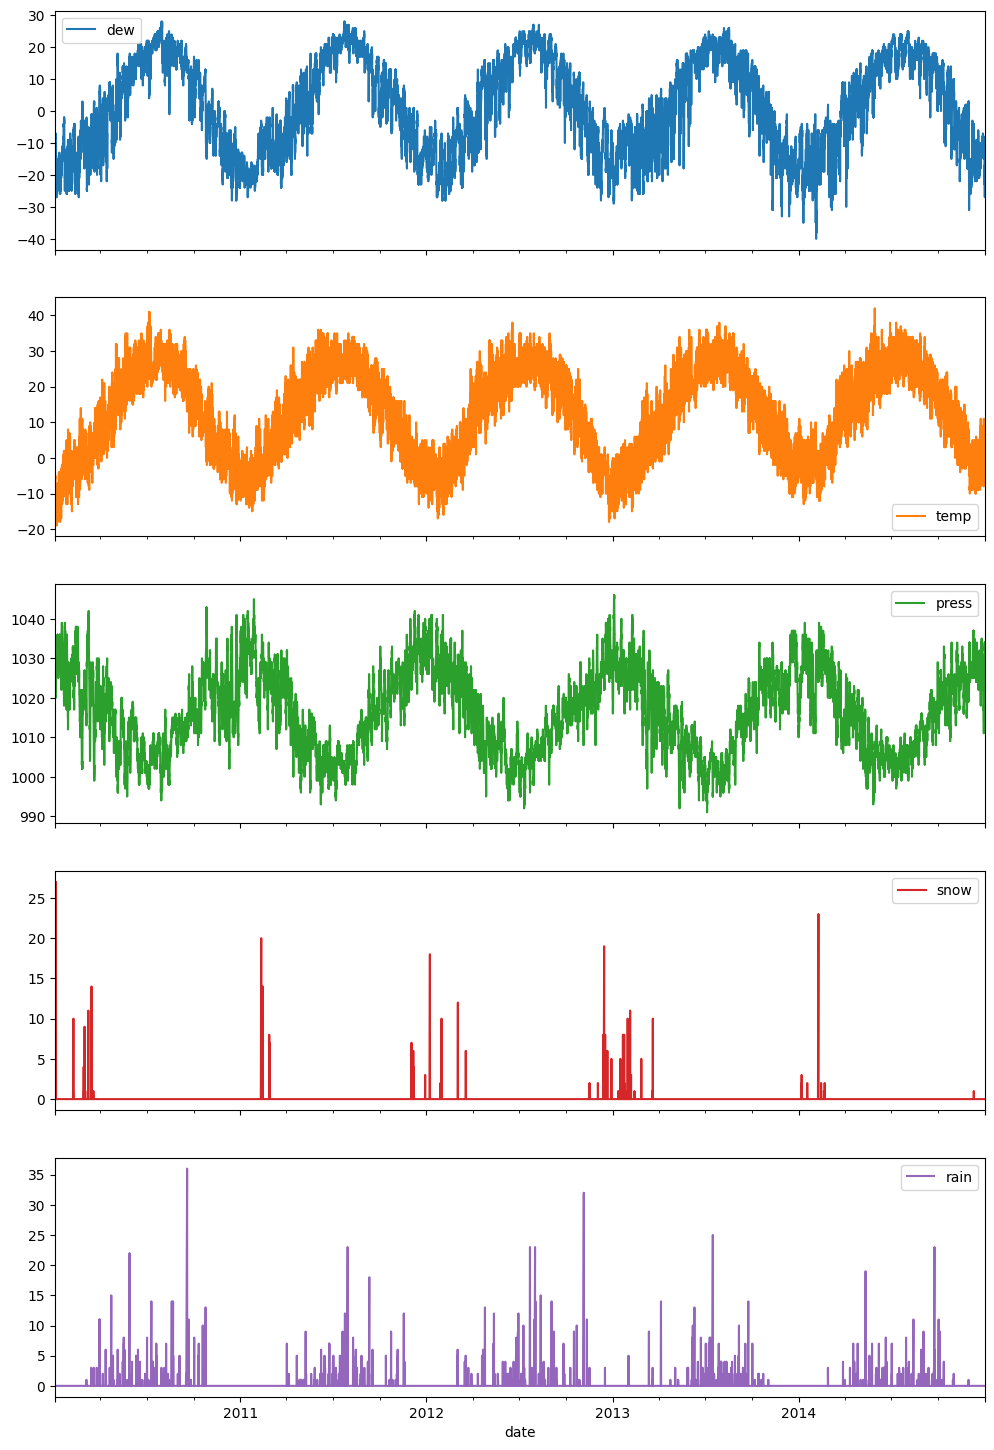

In [ ]:
raw_df[['dew', 'temp', 'press', 'wnd_dir', 'snow', 'rain']].plot(subplots=True, figsize=(12, 18))
plt.show()

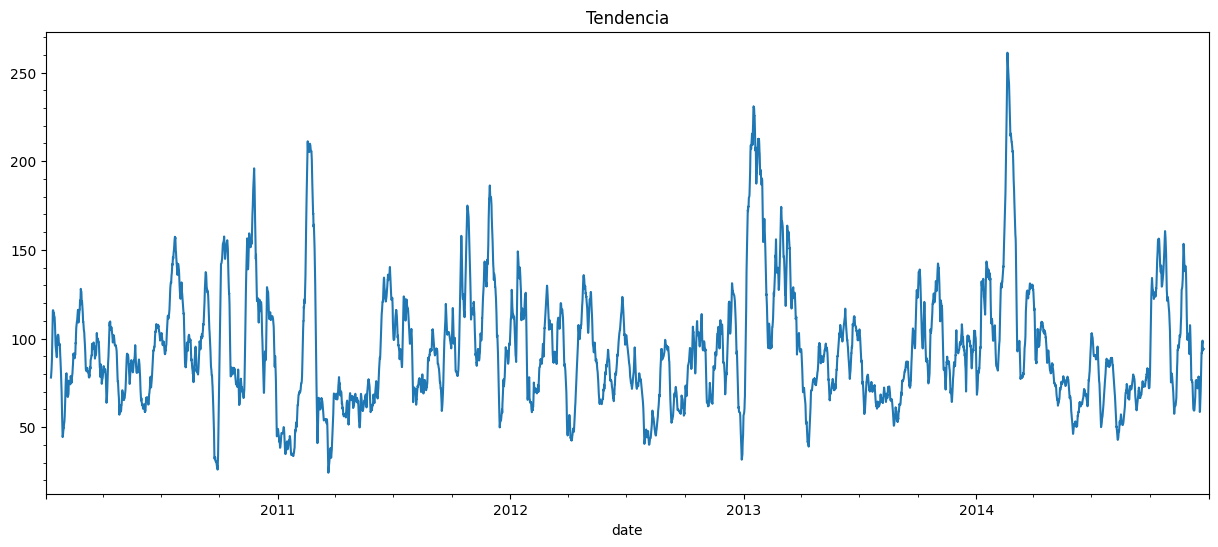

In [ ]:
df = raw_df.copy()
df.pop("wnd_dir")
result = seasonal_decompose(df['pollution'], model='additive', period=365)
plt.figure(figsize=(15, 6))
plt.title("Tendencia")
plt.minorticks_on()
result.trend.plot()
plt.show()

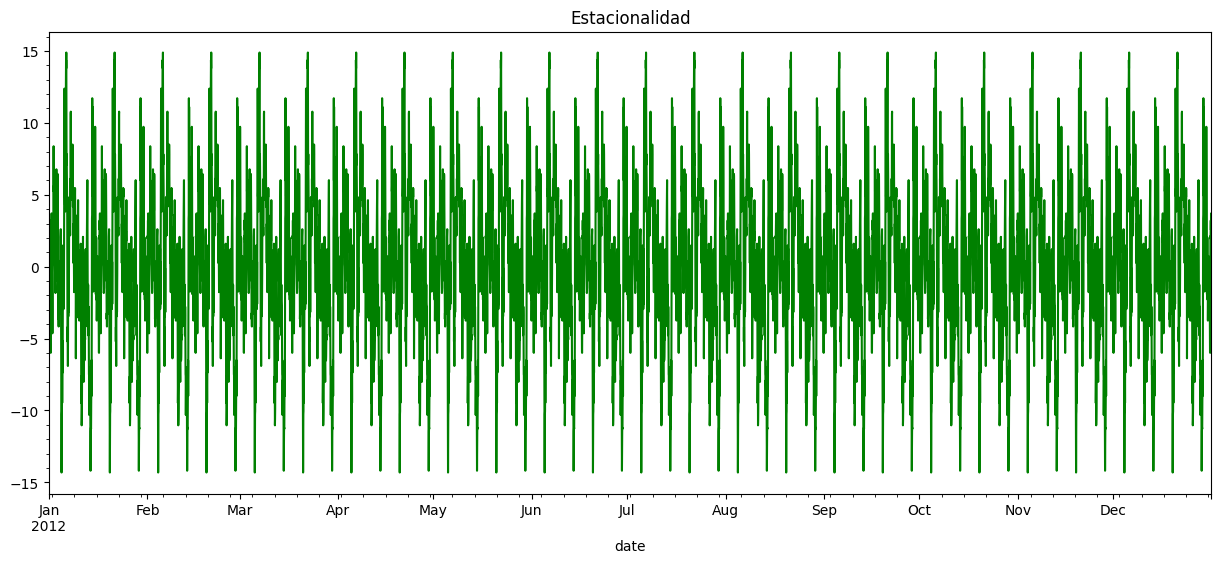

In [ ]:
plt.figure(figsize=(15, 6))
plt.title("Estacionalidad")
plt.minorticks_on()
result.seasonal["2012"].plot(color="green")
plt.show()

Tras visualizar la variable objetivo y las covariables es posible identificar patrones, sugiriendo una eventual estacionalidad, acontinuación se graficará la autocorrelación y autocorrelación parcial, la cual consiste en como se correlaciona la serie tiempo con una versión resagada (de temporalidad anterior de ella misma) y la aplicación del test aumentado de Dickey fuller a varios niveles de significancia.

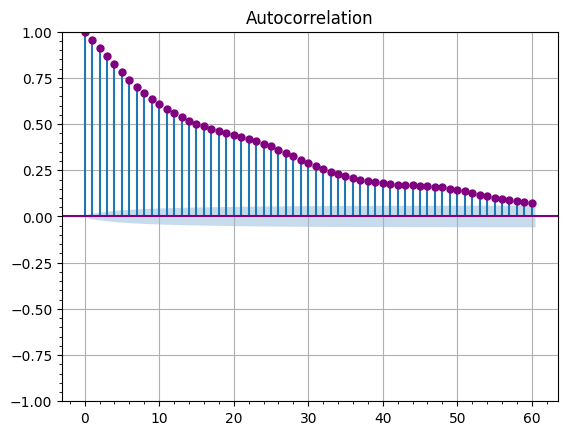

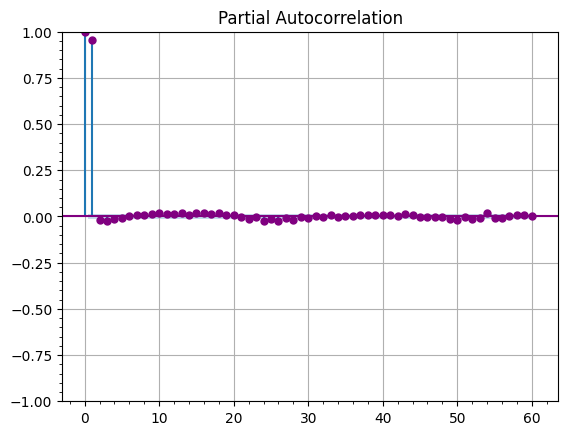

In [ ]:
plot_acf(df['pollution'], lags=60, color="purple", alpha=0.01)
plt.grid()
plt.minorticks_on()
plt.show()
plot_pacf(df['pollution'], lags=60, color="purple", alpha =0.01)
plt.grid()
plt.minorticks_on()
plt.show()

In [ ]:
#Comporando la estacionalidad de los datos a diferentes niveles de significancia (1%, 5% y 10%)
p_estacionalidad = sm.tsa.adfuller(raw_df['pollution'], maxlag=30, regression='c', autolag='AIC')
print('ADF Statc', p_estacionalidad[0])
print('p-valor:', p_estacionalidad[1])
print('Valor crítico:', p_estacionalidad[4])

ADF Statc -24.747770597744836
p-valor: 0.0
Valor crítico: {'1%': -3.4304994101792583, '5%': -2.8616060360236197, '10%': -2.5668051488274246}


al comparar el estadístico y los valores críticos para los distintos niveles de significancia y su respectivo p valor, se concluye que la serie presenta estacionalidad

## **Segmentación del conjunto de datos**

En la segunda sección se crean segmentaciones de datos, se reorganiza el arreglo de manera que pueda ser presentado a la red de aprendizaje profundo y se escalan a sus valores a un rango homogéneo para que la escala de medición de los valores no cree sesgo en el entrenamiento del modelo, además de realizar algunas visualizaciones.

In [ ]:
#División del conjunto de datos
tr_len = int(len(df)*0.8)
tst_len = int(len(df)*0.1)
val_len = df.shape[0] - tr_len - tst_len
print(tr_len, tst_len, val_len)

35040 4380 4380


In [ ]:
tr_df = df[0:tr_len]
val_df =df[tr_len: tr_len+val_len]
tst_df = df[tr_len+val_len:]
print(f"el tamaño del set del entrenamiento es :{tr_df.shape}")
print(f"el tamaño del set de validación es :{val_df.shape}")
print(f"el tamaño del set testeo es :{tst_df.shape}")

el tamaño del set del entrenamiento es :(35040, 7)
el tamaño del set de validación es :(4380, 7)
el tamaño del set testeo es :(4380, 7)


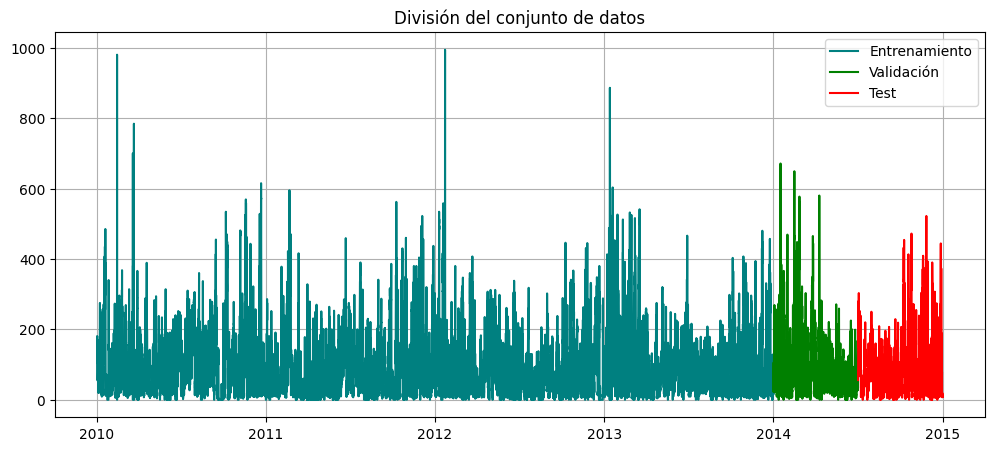

In [ ]:
fig, ax = plt.subplots(figsize = (12 ,5))
ax.plot(tr_df["pollution"], label = "Entrenamiento", color= "teal")
ax.plot(val_df["pollution"], label = "Validación", color= "green")
ax.plot(tst_df["pollution"], label = "Test", color="red")
plt.title("División del conjunto de datos")
plt.legend()
plt.grid()
plt.show()

In [ ]:
#Esta función está construida de manera que puede aplicarse modelos univariados
#Esta función reforma el arreglo de 2 dimensiones a 3 dimensiones
def ventana_paquetes_datos(array, tamaño_paquete_entrada, tamaño_paquete_salida):
    X, Y = [], []
    shape = array.shape

    if len(shape) == 1:
        filas, cols = array.shape[0], 1
    else:
        filas, cols = array.shape

    for i in range(filas - tamaño_paquete_entrada - tamaño_paquete_salida):
        X.append(array[i:i+tamaño_paquete_entrada, 0:cols])
        #En la linea siguiente se selecciona la variable a predecir, ser cuidadoso al seleccionar su index de columna
        Y.append(array[i + tamaño_paquete_entrada: i + tamaño_paquete_entrada + tamaño_paquete_salida, 0].reshape(tamaño_paquete_salida,1))

    x = np.array(X)
    y = np.array(Y)
    return x, y

In [ ]:
paquete_ent = 24
paquete_sal = 1

x_tr, y_tr = ventana_paquetes_datos(tr_df.values, paquete_ent, paquete_sal)
x_val, y_val = ventana_paquetes_datos(val_df.values, paquete_ent, paquete_sal)
x_ts, y_ts = ventana_paquetes_datos(tst_df.values, paquete_ent, paquete_sal)

In [ ]:
#Verificación de la dimensionalidad del código
print(f"subconjunto de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}")
print(f"subconjunto de validación - x_vl: {x_val.shape}, y_vl: {y_val.shape}")
print(f"subconjunto de test - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}")

subconjunto de entrenamiento - x_tr: (35015, 24, 7), y_tr: (35015, 1, 1)
subconjunto de validación - x_vl: (4355, 24, 7), y_vl: (4355, 1, 1)
subconjunto de test - x_ts: (4355, 24, 7), y_ts: (4355, 1, 1)


In [ ]:
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_val, 'y_vl': y_val,
    'x_ts': x_ts, 'y_ts': y_ts,
}

In [ ]:
print(f"la forma de x_tr_s: {data_in['x_tr'].shape}")
print(f"la forma de y_tr_s: {data_in['y_ts'].shape}")

la forma de x_tr_s: (35015, 24, 7)
la forma de y_tr_s: (4355, 1, 1)


In [ ]:
#Elaboración de la función de escalamiento
def escalar_dataset(data_input, col_ref):
    num_características = data_input['x_tr'].shape[2]
    col_ref = df.columns.get_loc(col_ref)
    # Generar listado con "scalers"
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(num_características)]
    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)
    # Escalamiento: se usarán los min/max del set de entrenamiento para la totalidad de los datasets
    # Escalamiento Xs
    for i in range(num_características):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_val[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])
    # Escalamiento Ys
    y_tr_s[:,:,0] = scalers[col_ref].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[col_ref].transform(y_val[:,:,0])
    y_ts_s[:,:,0] = scalers[col_ref].transform(y_ts[:,:,0])
    # Conformar ` de salida
    data_scal = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }
    return data_scal, scalers[col_ref]

In [ ]:
#Ejecucuón de la función de escalamiento
data_s, scaler = escalar_dataset(data_in, col_ref="pollution")

In [ ]:
#creando datasets de entrenamiento, validación y prueba
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

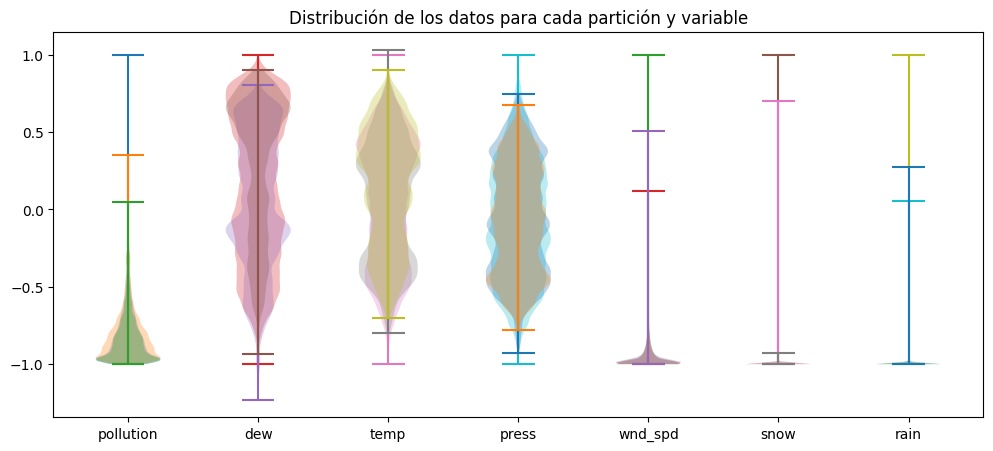

In [ ]:
#Visualización de las distribuciones de las variables
labels = ['pollution','dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain']
positions = np.arange(len(labels))

fig, ax = plt.subplots(figsize = (12 ,5))
for i in range(data_in['x_tr'].shape[2]):
  ax.violinplot(x_tr_s[:,:,i].flatten(), positions = [i])
  ax.violinplot(x_vl_s[:,:,i].flatten(), positions = [i])
  ax.violinplot(x_ts_s[:,:,i].flatten(), positions = [i])

ax.set_xticks(positions)
plt.title("Distribución de los datos para cada partición y variable")
ax.set_xticklabels(labels)
ax.autoscale()
plt.show()

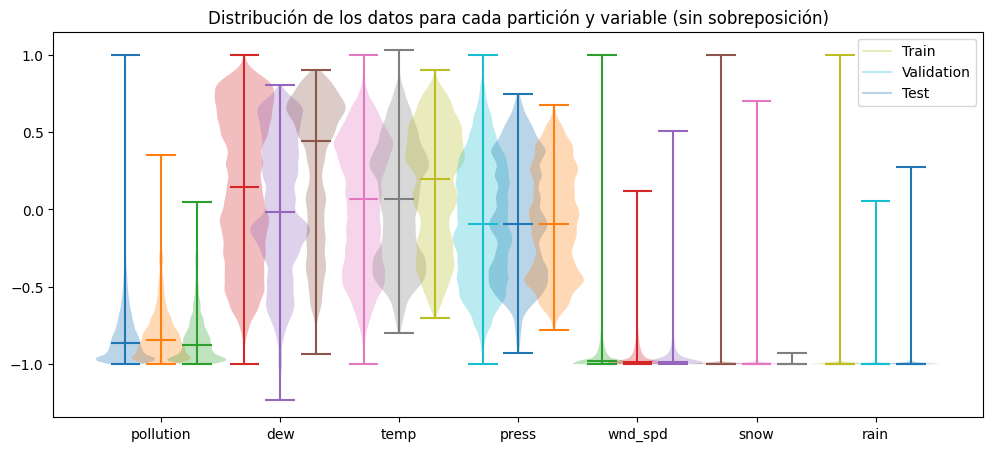

In [ ]:
labels = ['pollution','dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain']
positions = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(12, 5))

for i in range(len(labels)):
    parts_tr = ax.violinplot(x_tr_s[:, :, i].flatten(), positions=[positions[i] - 0.3], showmeans=False, showmedians=True)
    parts_vl = ax.violinplot(x_vl_s[:, :, i].flatten(), positions=[positions[i]], showmeans=False, showmedians=True)
    parts_ts = ax.violinplot(x_ts_s[:, :, i].flatten(), positions=[positions[i] + 0.3], showmeans=False, showmedians=True)

# Etiquetas de las columnas
ax.set_xticks(positions)
ax.set_xticklabels(labels)

# Agregar leyenda
legend_labels = ['Train', 'Validation', 'Test']
legend_colors = [parts_tr['bodies'][0].get_facecolor().flatten(),
                 parts_vl['bodies'][0].get_facecolor().flatten(),
                 parts_ts['bodies'][0].get_facecolor().flatten()]

custom_lines = [plt.Line2D([0], [0], color=color) for color in legend_colors]
ax.legend(custom_lines, legend_labels)
plt.title("Distribución de los datos para cada partición y variable (sin sobreposición)")
plt.show()

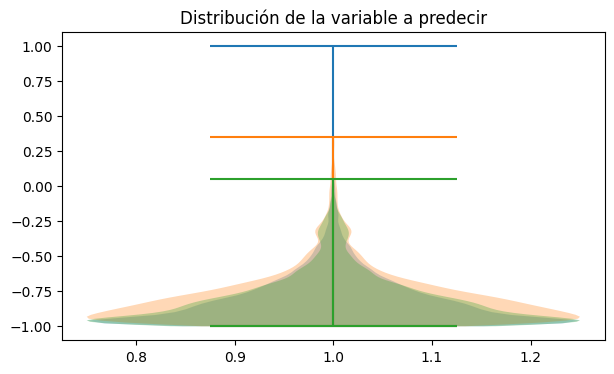

In [ ]:
#visualización de la variable respuesta
fig, ax = plt.subplots(figsize = (7 ,4))
ax.violinplot(y_tr_s[:,:,0].flatten())
ax.violinplot(y_vl_s[:,:,0].flatten())
ax.violinplot(y_ts_s[:,:,0].flatten())

ax.autoscale()
plt.title("Distribución de la variable a predecir")
plt.show()

In [ ]:
#Generando pseudoaleatoriedad para reproductibilidad
tf.random.set_seed(12896)
np.random.seed(12896)
tf.config.experimental.enable_op_determinism()

# **Elaboración y evaluación del modelo**

En la tercera sección del proyecto se elabora la arquitectura de la red, se entrena y valida con cada uno de los datasets correspondientes, finalmente se realizan las predicciones correspondientes para el set de test y se compara los valores predichos con los valores reales ára finalmente visualizar y realizar el proceso de selección de importancia para las características (PIF)



In [ ]:
#Generación del modelo
unds = 140
input = (x_tr_s.shape[1],x_tr_s.shape[2])
mod = Sequential()
mod.add(LSTM(units=unds, input_shape=input))
mod.add(Dense(paquete_sal, activation="linear"))

optim = RMSprop(learning_rate=0.00005)
mod.compile(optimizer=optim, loss=tf.keras.losses.MeanSquaredError())
mod.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 140)               82880     
                                                                 
 dense (Dense)               (None, 1)                 141       
                                                                 
Total params: 83021 (324.30 KB)
Trainable params: 83021 (324.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
EPOCHS = 80
BATCH_SIZE = 256
historia = mod.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=1
)

Epoch 1/80
137/137 [==============================] - 18s 118ms/step - loss: 0.0639 - val_loss: 0.0209
Epoch 2/80
137/137 [==============================] - 15s 110ms/step - loss: 0.0146 - val_loss: 0.0119
Epoch 3/80
137/137 [==============================] - 15s 111ms/step - loss: 0.0112 - val_loss: 0.0100
Epoch 4/80
137/137 [==============================] - 15s 110ms/step - loss: 0.0098 - val_loss: 0.0088
Epoch 5/80
137/137 [==============================] - 15s 112ms/step - loss: 0.0088 - val_loss: 0.0081
Epoch 6/80
137/137 [==============================] - 15s 109ms/step - loss: 0.0081 - val_loss: 0.0073
Epoch 7/80
137/137 [==============================] - 16s 116ms/step - loss: 0.0076 - val_loss: 0.0070
Epoch 8/80
137/137 [==============================] - 15s 111ms/step - loss: 0.0071 - val_loss: 0.0066
Epoch 9/80
137/137 [==============================] - 15s 110ms/step - loss: 0.0068 - val_loss: 0.0063
Epoch 10/80
137/137 [==============================] - 16s 116ms/step - l

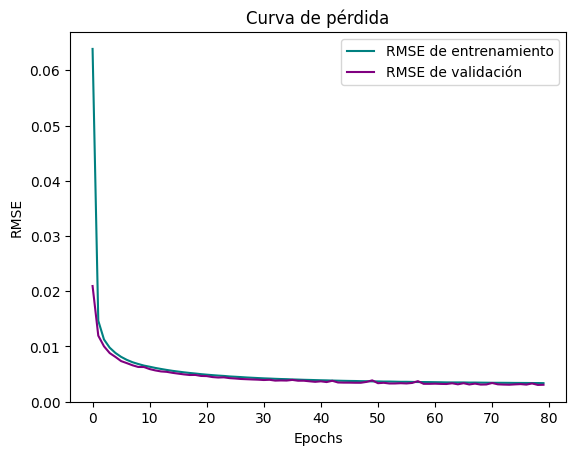

In [ ]:
#Curva de pérdida para verificar que el modelo no se haya sobreajustado
plt.plot(historia.history['loss'], label = "RMSE de entrenamiento", color="teal")
plt.plot(historia.history['val_loss'], label = "RMSE de validación", color="purple")
plt.title("Curva de pérdida")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [ ]:
RMSE_tr = mod.evaluate(x_tr_s, y_tr_s, verbose=0)
RMSE_vl = mod.evaluate(x_vl_s, y_vl_s, verbose=0)
RME_ts = mod.evaluate(x_ts_s, y_ts_s, verbose=0)
print(f"RMSE de entrenamiento: {RMSE_tr:.4f}")
print(f"RMSE de validación: {RMSE_vl:.4f}")
print(f"RMSE de test: {RME_ts:.4f}")

RMSE de entrenamiento: 0.0034
RMSE de validación: 0.0030
RMSE de test: 0.0023


In [ ]:
#Elaboración de una función de predicción y escalado inverso para comparación con los datos reales
def predecir(x, modelo, escalador):
    y_pred = modelo.predict(x)
    y_pred = y_pred.reshape(-1, 1)
    y_pr = escalador.inverse_transform(y_pred)
    y_pr = y_pr.flatten()
    return y_pr

In [ ]:
y_ts_pred = predecir(x_ts_s, mod, scaler)
y_ts_pred.shape

137/137 [==============================] - 2s 10ms/step


(4355,)

In [ ]:
#Comparación de máximos y mínimos
print(y_ts_pred.max())
print(y_ts_pred.min())
print(y_ts.max())
print(y_ts.min())

486.5006
-8.051966
522.0
0.0


In [ ]:
y_ts_flat = y_ts.flatten()
error_pred =  y_ts_pred - y_ts_flat
error_pred.shape

(4355,)

In [ ]:
errores = pd.DataFrame(data={"y_true":y_ts_flat, "y_pred":y_ts_pred})
errores.head()

,y_true,y_pred
0,256.0,263.050293
1,232.0,249.802612
2,212.0,229.610840
3,177.0,210.509216
4,175.0,181.586685


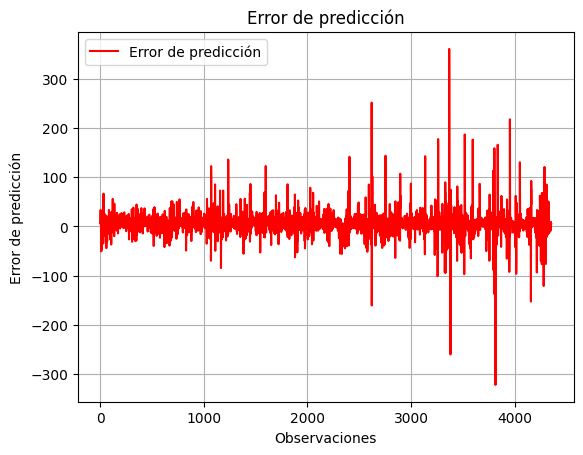

In [ ]:
#graficación de la diferencia entre los valores predichos y los reales como metrica del error
plt.plot(error_pred, label = "Error de predicción", color = "red")
plt.title("Error de predicción")
plt.xlabel("Observaciones")
plt.ylabel("Error de predicción")
plt.legend()
plt.grid()
plt.show()

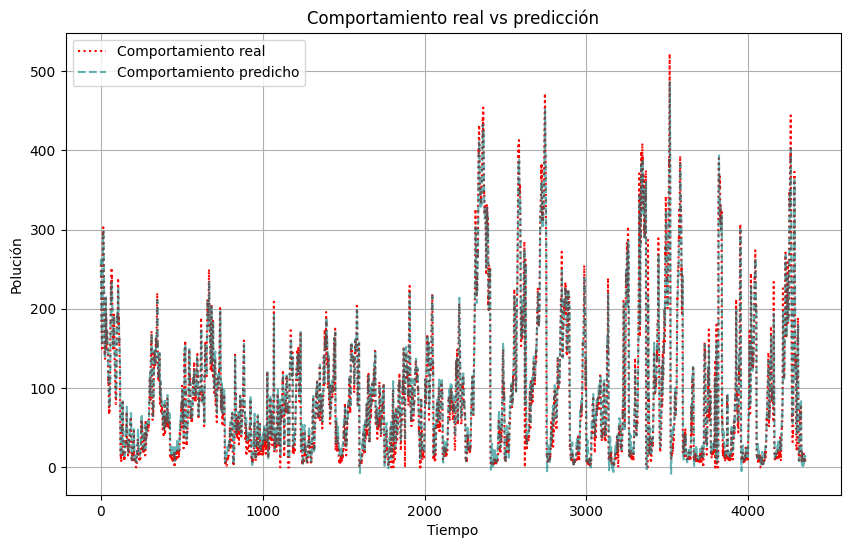

In [ ]:
#visualización de la serie predicha y la real
plt.figure(figsize=(10, 6))
plt.plot(errores["y_true"], label="Comportamiento real", color ="red", ls = ":")
plt.plot(errores["y_pred"], label= "Comportamiento predicho", color = "teal", ls = "--", alpha = 0.6)
plt.title("Comportamiento real vs predicción")
plt.xlabel("Tiempo")
plt.ylabel("Polución")
plt.legend()
plt.grid()
plt.show()

In [ ]:
#Elaboración de la función para visualización de importancia de características
def pfi_mod(modelo, x, y, cols):
  N_vars=x.shape[2]
  pfi_results=[]

  rmse= mod.evaluate(x, y, verbose=0)
  for i in range(N_vars):
    print(f"Permutando y calculando PFI para la variable {i+1} de {N_vars}")
    col_original = x[:,:,i].copy()
    np.random.shuffle(x[:,:,i])
    rmse_perm = mod.evaluate(x, y, verbose=0)
    pfi_results.append({"Variable":cols[i],"PFI":rmse_perm/rmse})
    x[:,:,i] = col_original

  PFI_df= pd.DataFrame(pfi_results).sort_values(by="PFI", ascending=False)
  return PFI_df

In [ ]:
PFI_df = pfi_mod(mod, x_ts_s, y_ts_s, df.columns)
PFI_df

Permutando y calculando PFI para la variable 1 de 7
Permutando y calculando PFI para la variable 2 de 7
Permutando y calculando PFI para la variable 3 de 7
Permutando y calculando PFI para la variable 4 de 7
Permutando y calculando PFI para la variable 5 de 7
Permutando y calculando PFI para la variable 6 de 7
Permutando y calculando PFI para la variable 7 de 7


,Variable,PFI
0,pollution,25.721779
2,temp,1.144160
1,dew,1.135107
3,press,1.020038
6,rain,1.005928
4,wnd_spd,1.003514
5,snow,0.999997


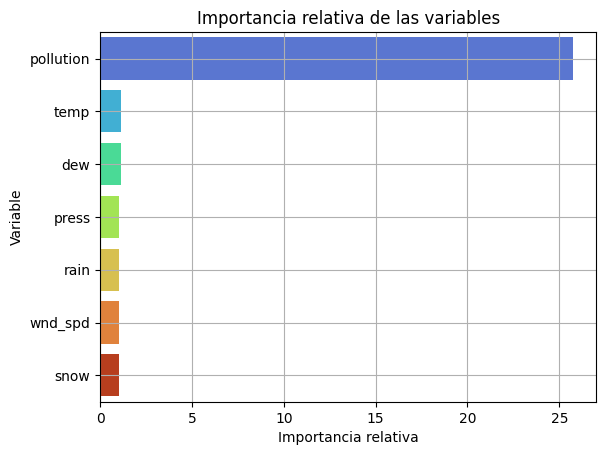

In [ ]:
ax = sns.barplot(x="PFI", y="Variable", data = PFI_df , palette="turbo")
ax.set_xlabel("Importancia relativa")
plt.title("Importancia relativa de las variables")
plt.grid()
plt.show()

# **Interpretación de los Resultados**

Los resultados del Permuted Feature Importances (PFI) indican la importancia de cada variable en el modelo de predicción de la polución. El PFI mide cuánto se degrada la precisión del modelo cuando los valores de una característica se permutan aleatoriamente, lo que rompe la relación entre la característica y el objetivo.

**pollution (25.721779):**

Esta variable tiene el valor de PFI más alto con una diferencia significativa respecto a las demás variables.
La alta puntuación sugiere que esta variable es extremadamente importante para el modelo. Permutar sus valores afecta drásticamente la precisión del modelo, lo que indica que la polución pasada es un predictor crucial para la polución futura.

**temp (1.144160):**

La temperatura es la segunda variable más importante, aunque su PFI es mucho menor que el de la polución.
Esto indica que, aunque la temperatura es relevante, su impacto en la precisión del modelo es moderado.

**dew (1.135107):**

El punto de rocío tiene una importancia similar a la de la temperatura.
Esto sugiere que la humedad en el aire también juega un papel en la predicción de la polución, aunque menos crucial que la temperatura y mucho menos que la polución pasada.

# **Conclusiones y potenciales mejoras**

Basado en los valores de RMSE (Error Cuadrático Medio Raíz) proporcionados, su red LSTM ha tenido un rendimiento excepcional en la predicción de series temporales sobre la contaminación, con RMSEs de entrenamiento, validación y prueba muy bajos, lo que indica una alta precisión y generalización del modelo.

Las importancias de características permutadas sugieren que la ‘contaminación’ es, con mucho, la característica más influyente, lo cual es esperado ya que probablemente es la variable objetivo que se está prediciendo. Las otras características como ‘temp’, ‘dew’, ‘press’, ‘rain’, ‘wnd_spd’ y ‘snow’ tienen puntuaciones de importancia significativamente más bajas, pero aún así contribuyen a las predicciones del modelo.

##**Observaciones:**

Los valores cercanos de RMSE entre los conjuntos de entrenamiento, validación y prueba sugieren que su modelo no está sobreajustado y generaliza bien a datos no vistos.
El dominio de la característica ‘pollution’ en importancia podría indicar que el modelo depende en gran medida de los valores pasados de contaminación para hacer predicciones.

Concluyendo  es posible crear un modelo univariado unistep o univariodo multistep dado que la variable respuesta aporta practicamente todo el poder predictivo al modelo pudiendo optimizar simpleza en el código y disminuyendo sustancialmente el requerimiento computacional.

Ahora paso a mencionar algunos aspectos a mejorar y algunos potenciales métodos para profundizar más.

##**Análisis Adicional:**

Validación cruzada: Para asegurar la robustez de su modelo, se podría realizar una validación cruzada k-fold.
Ingeniería de características: Experimentar con características adicionales o transformaciones que podrían capturar patrones más complejos en los datos.
Ajuste de hiperparámetros: Optimizar los hiperparámetros LSTM para mejorar potencialmente el rendimiento del modelo.
Interpretabilidad del Modelo: Utilizar técnicas como SHAP (SHapley Additive exPlanations) para obtener una comprensión más profunda de las contribuciones de las características.
Factores Externos: Investigar si los factores externos no incluidos en el conjunto de datos podrían mejorar las predicciones del modelo.
